# Simulation of observed spectrum

- author : Sylvie Dagoret-Campagne
- date july 7th 2017




** Notice it can handle several type of input objects **

In [51]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [52]:
print(theNotebook)

GenerateSimulationProfiles


In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
from astropy.table import Table, Column
import re
import os

In [54]:
import pandas as pd

In [55]:
from matplotlib.backends.backend_pdf import PdfPages

### Import libradtan tools for simulation

In [56]:
import sys
sys.path.append('../../spectrumsim/libradtransim')

In [57]:
from libsimulateTranspCTIOScattAbs import *

In [58]:
sys.path.append('../../spectrumsim')
import libCTIOTransm as ctiosim 

In [59]:
sys.path.append('../../humidity')
import humidity as hum
import libhumidity_ctio as humctio

### import pysynphot tools for CALSPEC SED

In [60]:
os.environ['PYSYN_CDBS']

'/Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs'

In [61]:
import pysynphot as S
from astropy.io import ascii

### CTIO Properties

In [62]:
path_ctiodata='../../spectrumsim/CTIOThroughput'
qe_filename='qecurve.txt'

### esthetic

In [63]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [64]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [65]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [66]:
infos='ctio10jun2017'

In [67]:
rootpath_rawimage="./reduced_fitsimages"
MIN_IMGNUMBER=135
MAX_IMGNUMBER=303
object_name='HD185975_HD205905 June 10th'
object_name_sim='HD185975_HD205905_Jun_10th'
SelectTagRe='^reduc_20170610_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^reduc_20170610_[0-9]+.fits$'
NBIMGPERLROW=4
calspec_sed={'HD205905':'hd205905_stis_003.fits','HD185975':'hd185975_stis_003.fits'}

In [68]:
#rootpath_rawimage="../OverScanRemove/trim_images"
#MIN_IMGNUMBER=144
#MAX_IMGNUMBER=357
#object_name='HD205905_Jun_08th'
#SelectTagRe='^trim_20170608_([0-9]+).fits$' # regular expression to select the file
#SearchTagRe='^trim_20170608_[0-9]+.fits$'
#NBIMGPERLROW=4
#calspec_sed='hd205905_stis_003.fits'

In [69]:
logfile='logbk_'+object_name+'_'+infos+'.fits'
pandaslogfile='logbk_'+object_name+'_'+infos+'.csv'

In [70]:
outputfitsfile='AllSimSpectra_'+object_name_sim+'.fits'

In [71]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [72]:
ensure_dir(dir_top_images)

## Get list of airmass

In [73]:
df=pd.read_csv(pandaslogfile)

In [74]:
df.head()

,Unnamed: 0,number,airmass,date,filename,exposure,zenith,temperature,pressure,humidity,windspeed,seeing,filter1,filter2,object
0,0,139,1.874,2017-06-11T05:34:06.396,./reduced_fitsimages/reduc_201,30.0,57.824001,13.5,778.0,23.0,17.4,0.712,RG715,Thor300,HD185975
1,1,140,1.873,2017-06-11T05:35:28.909,./reduced_fitsimages/reduc_201,30.0,57.816002,13.5,778.0,23.0,13.2,0.620,RG715,HoloPhP,HD185975
2,2,141,1.873,2017-06-11T05:36:54.407,./reduced_fitsimages/reduc_201,60.0,57.818001,13.6,778.0,22.0,15.2,0.639,RG715,HoloPhAg,HD185975
3,3,142,1.873,2017-06-11T05:38:47.099,./reduced_fitsimages/reduc_201,60.0,57.806000,13.6,778.0,22.0,16.4,0.747,RG715,HoloAmAg,HD185975
4,4,143,1.393,2017-06-11T05:41:15.751,./reduced_fitsimages/reduc_201,30.0,44.188999,13.4,778.0,22.0,13.1,0.717,RG715,Thor300,HD205905


In [75]:
airmasses=df["airmass"]
date=df['date']
expo=df['exposure']
datafile=df['filename']
temperature=df['temperature']
pressure=df['pressure']
humidity=df['humidity']
seeing=df['seeing']
thefilter=df['filter1']
disperser=df['filter2']
theobject=df['object']

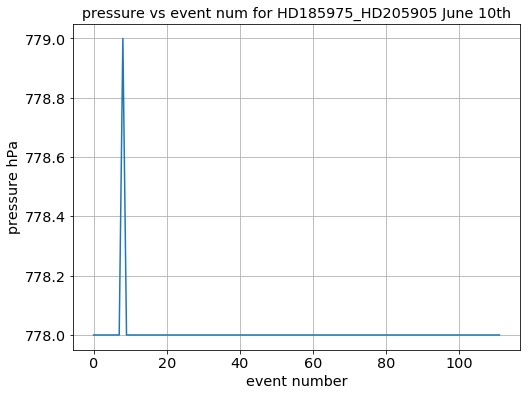

In [76]:
plt.plot(pressure)
thetitle="pressure vs event num for {}".format(object_name)
plt.title(thetitle)
plt.xlabel("event number")
plt.ylabel("pressure hPa")
plt.grid()
plt.savefig("pressurevsnum.pdf")

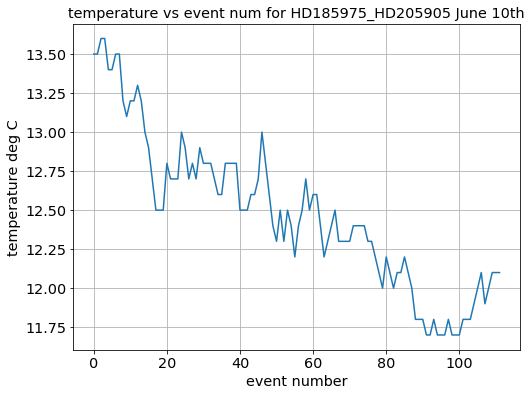

In [77]:
plt.plot(temperature)
thetitle="temperature vs event num for {}".format(object_name)
plt.title(thetitle)
plt.xlabel("event number")
plt.ylabel("temperature deg C")
plt.grid()
plt.savefig("temperaturevsnum.pdf")

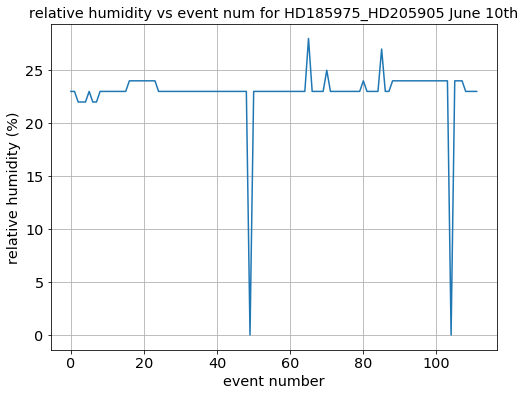

In [78]:
plt.plot(humidity)
thetitle="relative humidity vs event num for {}".format(object_name)
plt.title(thetitle)
plt.xlabel("event number")
plt.ylabel("relative humidity (%)")
plt.grid()
plt.savefig("relhumidityvsnum.pdf")

## Compute pwv required for libradtran

In [79]:
pwv=humctio.HRtoPWV(humidity/100.,pressure,temperature+273.0)

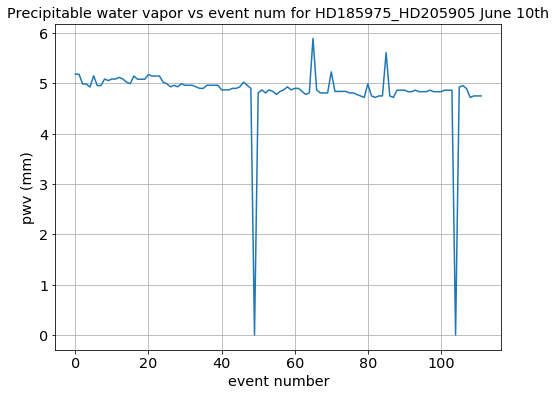

In [80]:
plt.plot(pwv)
thetitle="Precipitable water vapor vs event num for {}".format(object_name)
plt.title(thetitle)
plt.xlabel("event number")
plt.ylabel("pwv (mm)")
plt.grid()
plt.savefig("pwvvsnum.pdf")


## Get quantum efficiency

In [81]:
wl_qe,tr_qe=ctiosim. Get_QE()

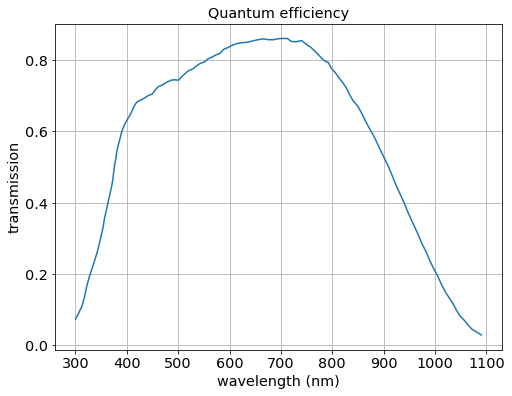

In [82]:
plt.plot(wl_qe,tr_qe)
plt.grid()
plt.title('Quantum efficiency')
plt.xlabel('wavelength (nm)')
plt.ylabel('transmission')

In [83]:
bp_ctio_qe = S.ArrayBandpass(wl_qe*10.,tr_qe, name='CTIO QE')

## Get mirror

In [84]:
wl_m,tr_m=ctiosim. Get_Mirror()

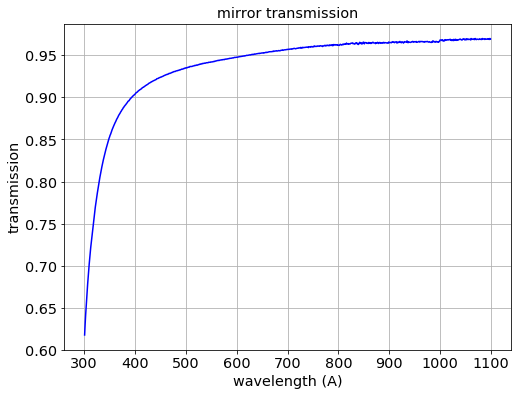

In [85]:
plt.plot(wl_m,tr_m,'b-')
plt.grid()
plt.title('mirror transmission')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')

In [86]:
bp_ctio_m = S.ArrayBandpass(wl_m*10.,tr_m*tr_m, name='CTIO Mirror2')  # two mirrors

In [87]:
bp_ctio=bp_ctio_m*bp_ctio_qe

### Get Filter

In [88]:
wl_f_red,tr_f_red=ctiosim.Get_RG175()
wl_f_blue,tr_f_blue=ctiosim.Get_FGB37()

In [89]:
bp_ctio_f_red = S.ArrayBandpass(wl_f_red*10.,tr_f_red, name='RG175')  # two mirrors
bp_ctio_f_blue = S.ArrayBandpass(wl_f_blue*10.,tr_f_blue, name='FGB37')  # two mirrors

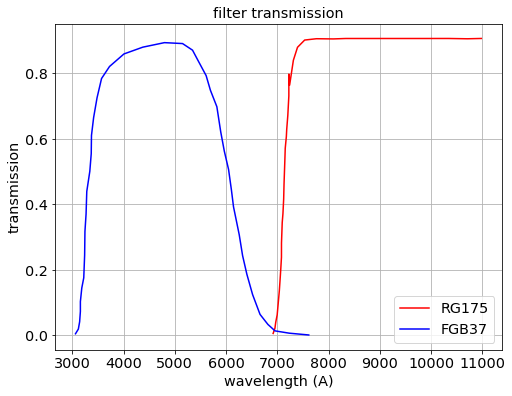

In [90]:
plt.plot(bp_ctio_f_red.wave,bp_ctio_f_red.throughput,color='red',label='RG175')
plt.plot(bp_ctio_f_blue.wave,bp_ctio_f_blue.throughput,color='blue',label='FGB37')
plt.grid()
plt.title('filter transmission')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')
plt.legend()

### Combine

#### With filter

In [91]:
bp_ctio_red=bp_ctio_qe*bp_ctio_m*bp_ctio_f_red
bp_ctio_blue=bp_ctio_qe*bp_ctio_m*bp_ctio_f_blue

#### witout filter

In [92]:
bp_ctio_nof=bp_ctio_qe*bp_ctio_m

### Please select the bp_ctio below

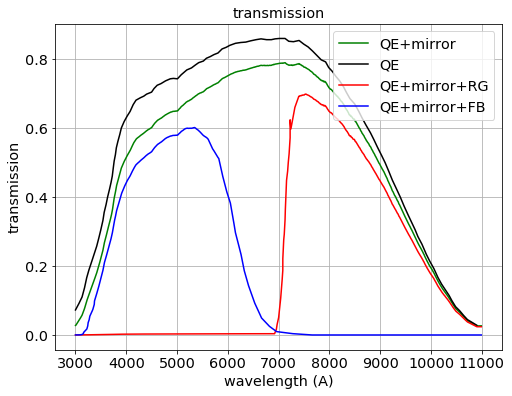

In [93]:
plt.plot(bp_ctio.wave,bp_ctio.throughput,'g-',label='QE+mirror')
plt.plot(wl_qe*10,tr_qe,'k-',label='QE')
plt.plot(bp_ctio_red.wave,bp_ctio_red.throughput,'r-',label='QE+mirror+RG')
plt.plot(bp_ctio_blue.wave,bp_ctio_blue.throughput,'b-',label='QE+mirror+FB')
plt.title('transmission')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')
plt.grid()
plt.legend()

## Get SED from CALSPEC 

- using Pysynphot

In [94]:
CTIO_COLL_SURF=0.9*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [95]:
S.refs.setref(area=CTIO_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, delta=10, log=False)

# Simulate atmosphere

In [96]:
all_wl_atm= []
all_tr_atm= []
all_bp_atm = []
PWV=4.
OZ=300.

In [97]:
for index,am in np.ndenumerate(airmasses):
    idx=index[0]
    #calculate the atmosphere
    path,file=ProcessSimulation(am,pwv[idx],OZ,pressure[idx])   
    fullfilename=os.path.join(path,file)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]
    all_wl_atm.append(wl_atm)
    all_tr_atm.append(tr_atm)
    atm_filter_name='CTIO atm {}'.format(idx)
    bp_atm = S.ArrayBandpass(wl_atm*10.,tr_atm, name=atm_filter_name)  # Pysynphot pass band
    all_bp_atm.append(bp_atm) 

--------------------------------------------
 2) airmass =  1.87399995327
 2) pwv =  5.18232352357
 3) oz =  300.0
 4) pressure  =  778.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z18_wv51_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z18_wv51_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret-campagnesylvie/MacOsX/LSST/softs/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z18_wv51_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z18_wv51_oz30.OUT')
--------------------------------------------
 2) airmass =  1.87300002575
 2) pwv =  5.18232352357
 3) oz =  300.0
 4) pressure  =  778.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z18_wv51_oz30.INP')
('Output to file                : ',

## Observed spectra

- calculate the observed spectra and save it in list

In [98]:
print thefilter

0      RG715
1      RG715
2      RG715
3      RG715
4      RG715
5      RG715
6      RG715
7      RG715
8      RG715
9      RG715
10     RG715
11     RG715
12     RG715
13     RG715
14     RG715
15     RG715
16     RG715
17     RG715
18     RG715
19     RG715
20     RG715
21     RG715
22     RG715
23     RG715
24     RG715
25     RG715
26     RG715
27     RG715
28     RG715
29     RG715
       ...  
82     RG715
83     RG715
84     RG715
85     RG715
86     RG715
87     RG715
88     RG715
89     RG715
90     RG715
91     RG715
92     RG715
93     RG715
94     RG715
95     RG715
96     RG715
97     RG715
98     RG715
99     RG715
100    RG715
101    RG715
102    RG715
103    RG715
104    RG715
105    RG715
106    RG715
107    RG715
108    RG715
109    RG715
110    RG715
111    RG715
Name: filter1, dtype: object


In [99]:
all_obs_spectra = []
all_obs_wl= []
all_obs_fluxes = []

for index,am in np.ndenumerate(airmasses):
    idx=index[0]
    
     # retrieve the SED
    theobjectname=theobject[idx]
    sed_filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec',calspec_sed[theobjectname])
    sed = S.FileSpectrum(sed_filename)
    
    
    # retrieve the filter
    if thefilter[idx]=='RG715':
        bp_ctio=bp_ctio_red
    elif thefilter[idx]=='FGB37':
        bp_ctio=bp_ctio_blue
    else:
        bp_ctio=bp_ctio_nof
        
    atm_filter_name='CTIO atm {}'.format(idx)
    
    # atmosphere passband
    the_bp_atm= S.ArrayBandpass(all_wl_atm[idx]*10.,all_tr_atm[idx], name=atm_filter_name)  # Pysynphot pass band
    # total passband
    bp_ctio_atm = bp_ctio*the_bp_atm # Multply atm tansmission by CCD QE efficiciency
    bp_ctio_atm.binning=10.
    
    # now compute the observed spectrum
    obs_ctio = S.Observation(sed,bp_ctio_atm)
    
    #backup
    all_obs_spectra.append(obs_ctio)
    all_obs_wl.append(obs_ctio.wave)
    all_obs_fluxes.append(obs_ctio.flux) 
    

Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Warning, 6 of 3739 bins contained negative fluxes; they have

(0, 10000)

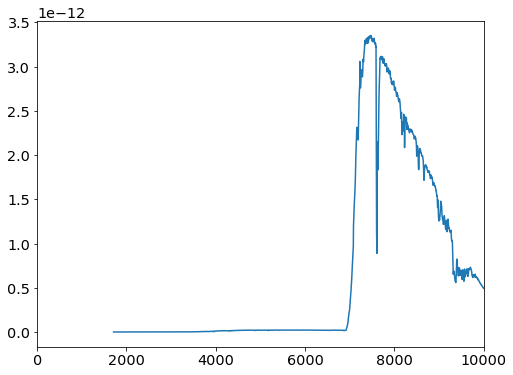

In [100]:
sel=4
plt.plot(all_obs_wl[sel], all_obs_fluxes[sel])
plt.xlim(0,10000)

In [115]:
all_len=[len(all_obs_wl[i]) for i in range(len(all_obs_wl))]

In [118]:
min_len=min(all_len)

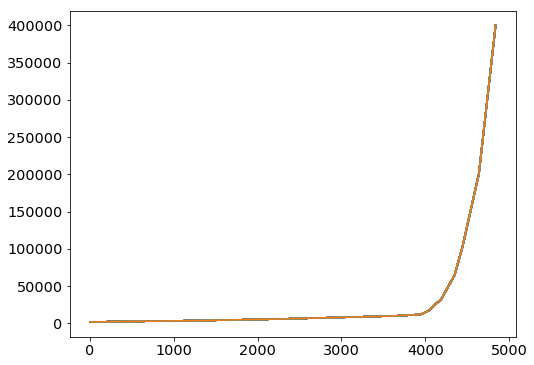

In [117]:
for i in range(len(all_obs_wl)):
    plt.plot(all_obs_wl[i])


In [124]:
def MakeSimNpArray(all_simwavelength,all_simspectra,minlen):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0][0:minlen])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=minlen
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=np.copy(all_simspectra[ispec-1][0:minlen])
    return dataout

In [125]:
spectra_out=MakeSimNpArray(all_obs_wl,all_obs_fluxes,min_len)

112  ,  4839


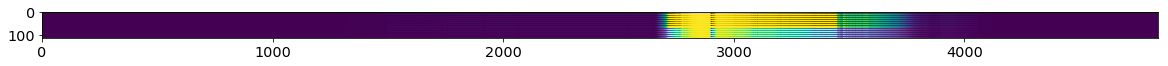

In [126]:
plt.figure(figsize=(20,20))
plt.imshow(spectra_out[:,:],vmin=0,vmax=1e-12)

In [127]:
def CompareSpectrumProfile(allspectra,object_name,dir_top_img):
    """
    CompareSpectrumProfile
    =====================
    
    """
    shortfilename='CompareSimSpec_'+object_name+'.pdf'
    title="Compare simulated spectra of {}".format(object_name)
    figfilename=os.path.join(dir_top_img,shortfilename)
    pp = PdfPages(figfilename) # create a pdf file
    
    
    f, axarr = plt.subplots(1,1,figsize=(25,15))
    f.suptitle(title,size=20)
    
    NBSPEC=allspectra.shape[0]-1
    wl=allspectra[0]
    
    
    min_z=truncate(min(airmasses),2)
    max_z=truncate(max(airmasses),2)
    
    maxim_y_to_plot= []

    texte='airmass : {} - {} '.format(min_z,max_z)
    
    for index in np.arange(0,NBSPEC):
                
       
        axarr.plot(wl,allspectra[index+1],'-')
        maxim_y_to_plot.append(allspectra[index+1].max())
    
    max_y_to_plot=max(maxim_y_to_plot)
    axarr.set_ylim(0,max_y_to_plot)
    axarr.text(0.,max_y_to_plot*0.9, texte ,verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    axarr.grid(True)
    axarr.set_xlim(0,12000)
    
    axarr.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.grid(b=True, which='major', color='k', linewidth=2.0)
    axarr.grid(b=True, which='minor', color='grey', linewidth=0.5)
    
    
    
    axarr.set_xlabel("wavelength (A)")
    
        
    f.savefig(pp, format='pdf')
    f.show()
    
    pp.close()     
    

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


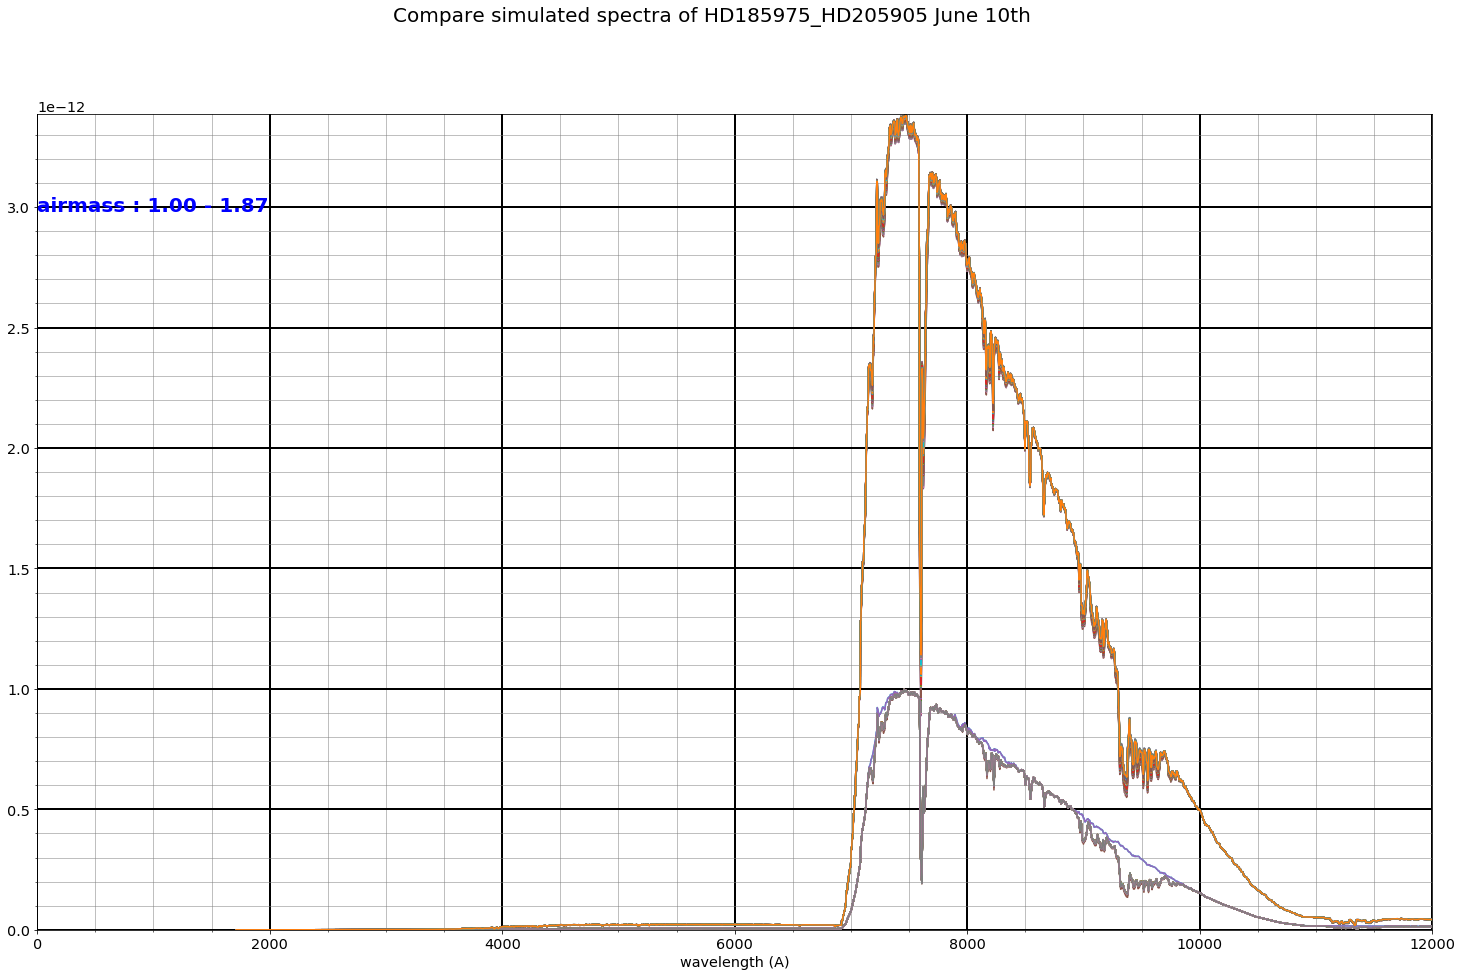

In [128]:
CompareSpectrumProfile(spectra_out,object_name,dir_top_images)

## Save output file

In [129]:
prihdu = fits.PrimaryHDU(data=spectra_out)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfitsfile,overwrite=True)

In [130]:
spectra_out.shape

(113, 4839)